<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Thie project aims to predict the future 24 hours of energy demand. This is a multivariate time series forecasting project.

##  1. Data Preprocessing


## 1-1. Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
df = pd.read_csv('energy_dataset.csv', usecols=['time','total load actual', 'price actual'])

In [3]:
df.shape

(35064, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35064 non-null  object 
 1   total load actual  35028 non-null  float64
 2   price actual       35064 non-null  float64
dtypes: float64(2), object(1)
memory usage: 821.9+ KB


In [5]:
df.head()

,time,total load actual,price actual
0,2015-01-01 00:00:00+01:00,25385.0,65.41
1,2015-01-01 01:00:00+01:00,24382.0,64.92
2,2015-01-01 02:00:00+01:00,22734.0,64.48
3,2015-01-01 03:00:00+01:00,21286.0,59.32
4,2015-01-01 04:00:00+01:00,20264.0,56.04


## 1-2. Managing Time Column

In [6]:
# Manage time column

# I usually set the datetime as the index. You may keep the origional index and datetime column,
# then you just need to use datetime column instead of index later, when selecting data.

# Case X
#df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
#df.drop(['Date', 'Time'], axis=1, inplace=True)
#df.set_index('datetime', inplace=True)
df['time'] = pd.to_datetime(df['time'])


df.set_index('time', inplace=True)

# Ensure time series is sorted
df.sort_index(inplace=True)

# Calculate time differences

#time_diffs = df.index.to_series().diff()

# Identify any irregularities, apart from the first row
#irregularities = time_diffs[time_diffs != time_diffs.mode()[0]][1:]

# Display irregularities, if any
#if irregularities.empty:
#    print("No irregularities found.")
#else:
#    print("Irregularities found at:")
#    print(irregularities)

<ipython-input-6-d74f238a0c71>:10: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['time'] = pd.to_datetime(df['time'])


## 1-3. Handling Missing Values

In [7]:
# Replacing Specific Non-Numeric Values with NaN

# List of non-numeric values to replace
non_numeric_values = ['?', 'N/A', '-', '']

for col in df.columns:
    df[col] = df[col].replace(non_numeric_values, np.nan)
    df[col] = df[col].astype('float64')

In [8]:
# Check out null value situation
df.isna().sum()

,0
total load actual,36
price actual,0


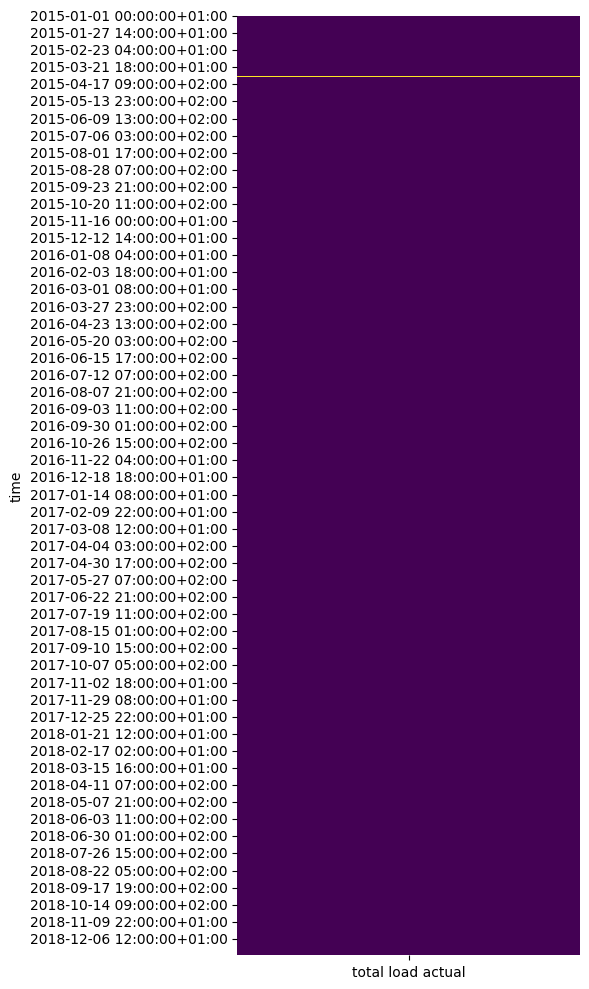

In [9]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.heatmap(df['total load actual'].isna().to_frame(), cbar=False, cmap='viridis', ax=ax)
plt.tight_layout()
plt.show()

In [10]:
# Impute the missing values with interpolation
df['total load actual'] = df['total load actual'].interpolate(method='linear')

In [11]:
df.isna().sum()

,0
total load actual,0
price actual,0


## 1-4. Formating Data Types

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  35064 non-null  float64
 1   price actual       35064 non-null  float64
dtypes: float64(2)
memory usage: 821.8+ KB


## 2. EDA

## 2-1. Visualizing Data

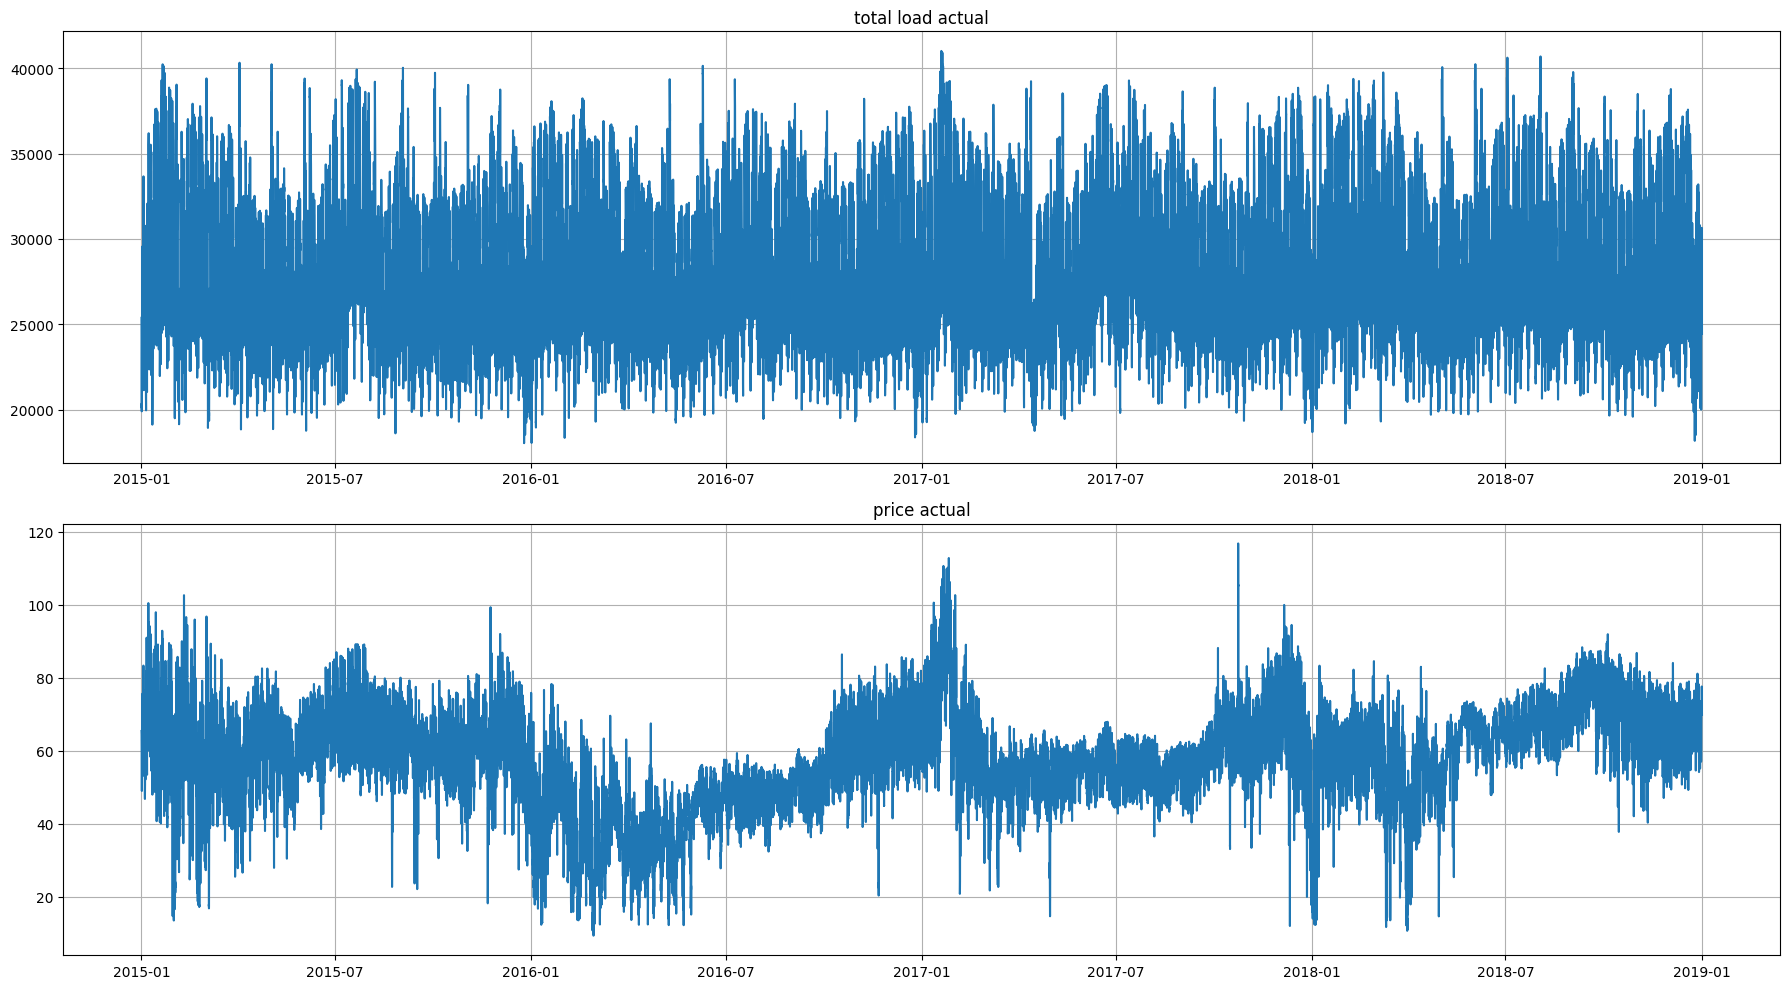

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(18, 10))

for i, col in enumerate(df.columns[:]):
    axs[i].plot(df[col])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

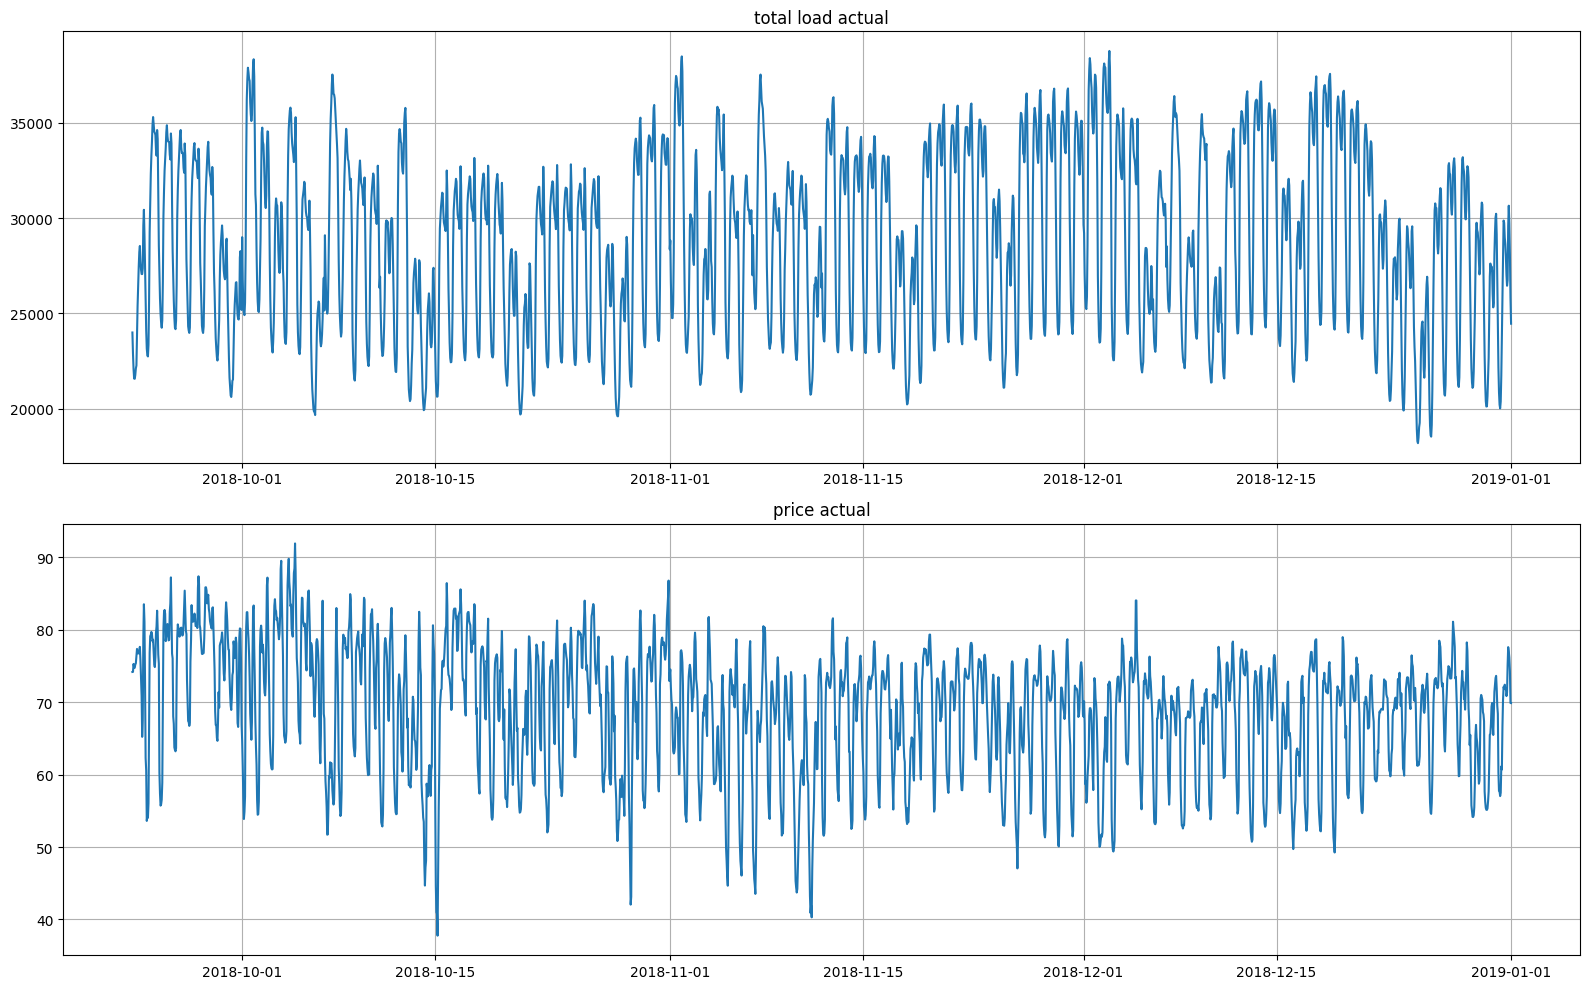

In [14]:
# Visualize a few data at the end

fig, axs = plt.subplots(2, 1, figsize=(16, 10))

for i, col in enumerate(df.columns[:]):
    axs[i].plot(df[col][-24*100:])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## 2-2 Statistics of the Dataset

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total load actual,35064.0,28698.281385,4575.828854,18041.00,24807.0000,28902.00,32194.25,41015.0
price actual,35064.0,57.884023,14.204083,9.33,49.3475,58.02,68.01,116.8


From the statistics, we can see that two features are in different scale, we need to do a scaling before fitting a model.

In [16]:
df.corr()

,total load actual,price actual
total load actual,1.000000,0.435253
price actual,0.435253,1.000000


## 2-3 Data Preparation

### 2-3-1 Features Selection

In [17]:
df.columns.to_list()

['total load actual', 'price actual']

In [18]:
# Since there are only two features, we don't need to select features.

used_cols = ['total load actual', 'price actual']

for col in used_cols:
    df[f'{col}_roll'] = df[col].rolling(window=3).mean()
df.dropna(inplace=True)

input_cols = ['total load actual_roll', 'price actual_roll']
target_cols = ['total load actual', 'price actual']

dr = df[input_cols + target_cols].copy()


### 2-3-2 Normalization

In [19]:
# Example: Applying Min-Max Scaling to your dataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for col in input_cols:
    dr[col] = scaler.fit_transform(dr[[col]])

In [20]:
dr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total load actual_roll,35062.0,0.470133,0.198004,0.00,0.305456,0.476674,0.619416,1.0
price actual_roll,35062.0,0.471256,0.135682,0.00,0.389787,0.474207,0.567517,1.0
total load actual,35062.0,28698.498988,4575.867084,18041.00,24807.250000,28902.000000,32194.750000,41015.0
price actual,35062.0,57.883608,14.204382,9.33,49.342500,58.020000,68.010000,116.8


### 2-3-3 Train Test Split

In [45]:
split_step = int(len(dr)*0.8)
train = dr.iloc[:split_step]
val = dr.iloc[split_step:]

## 2-3-4 Generate Dataset for Models



```
window_size = 3

dataset = tf.data.Dataset.from_tensor_slices(train)
dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

for window in dataset.take(1):
  print(window.numpy())
  print(f'shape: {window.numpy().shape}')

[[  0.482  247.138    0.       0.       0.       0.484 ]
 [  0.4824 247.212    0.       0.       0.       0.484 ]
 [  0.4824 247.364    0.       0.       0.       0.482 ]
 [  0.4828 247.564    0.       0.       0.       0.482 ]]
shape: (4, 6)

for window in dataset.take(1):
  print(window[:-1,:-1], window[-1][-1])

tf.Tensor(
[[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]], shape=(3, 5), dtype=float64) tf.Tensor(0.482, shape=(), dtype=float64)

# group into features and lables
dataset = dataset.map(lambda window: (window[:-1,:-1], window[-1][-1]))

for x, y in dataset.take(2):
  print('x = ', x.numpy())
  print('y = ', y.numpy())
  print()

x =  [[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]]
y =  0.482

x =  [[  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]
 [  0.4828 247.564    0.       0.       0.    ]]
y =  0.482
```



In [32]:
# Parameters
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 10000 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

#### 2-3-4-1 Single Step

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, feature_columns, label_columns, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method
      feature_columns (list of str or int) - the names or indices of the columns to be used as features
      label_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, map feature_columns and label_columns from names to indices
    if column_names is not None:
        feature_columns = [column_names.index(col) if isinstance(col, str) else col for col in feature_columns]
        label_columns = [column_names.index(col) if isinstance(col, str) else col for col in label_columns]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-1], feature_columns, axis=-1),
                                          tf.gather(window[-1], label_columns, axis=-1)))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset





##### Single Step Single Output



In [ ]:
column_names = dr.columns.to_list()
input_cols = ['total load actual_roll', 'price actual_roll']
target_cols = ['total load actual']
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size, feature_columns=input_cols, label_columns=target_cols, column_names=column_names)

```
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 60, 5)
shape of second element: (32, 1)

```

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten


# Build the RNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu',
                          input_shape=[window_size, len(input_cols)]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(1),
])
# Compile the model
model.compile(loss="mse", optimizer="adam")

# Train the model
model.fit(train_set, epochs=10)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 51s 50ms/step - loss: 766544896.0000
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


876/876 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - loss: 64430112.0000
Epoch 3/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - loss: 20938582.0000
Epoch 4/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - loss: 21158172.0000
Epoch 5/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 84s 51ms/step - loss: 20903506.0000
Epoch 6/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - loss: 18080926.0000
Epoch 7/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - loss: 1248935.0000
Epoch 8/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - loss: 893808.4375
Epoch 9/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - loss: 798975.1250
Epoch 10/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 81s 49ms/step - loss: 716617.1250


In [ ]:
def model_forecast(model, test_series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size
    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(test_series.iloc[:,:-1]) #separate out the label

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [ ]:
forecast = model_forecast(model, val, window_size, batch_size)

218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
actual = val.iloc[window_size:,-1].to_list()

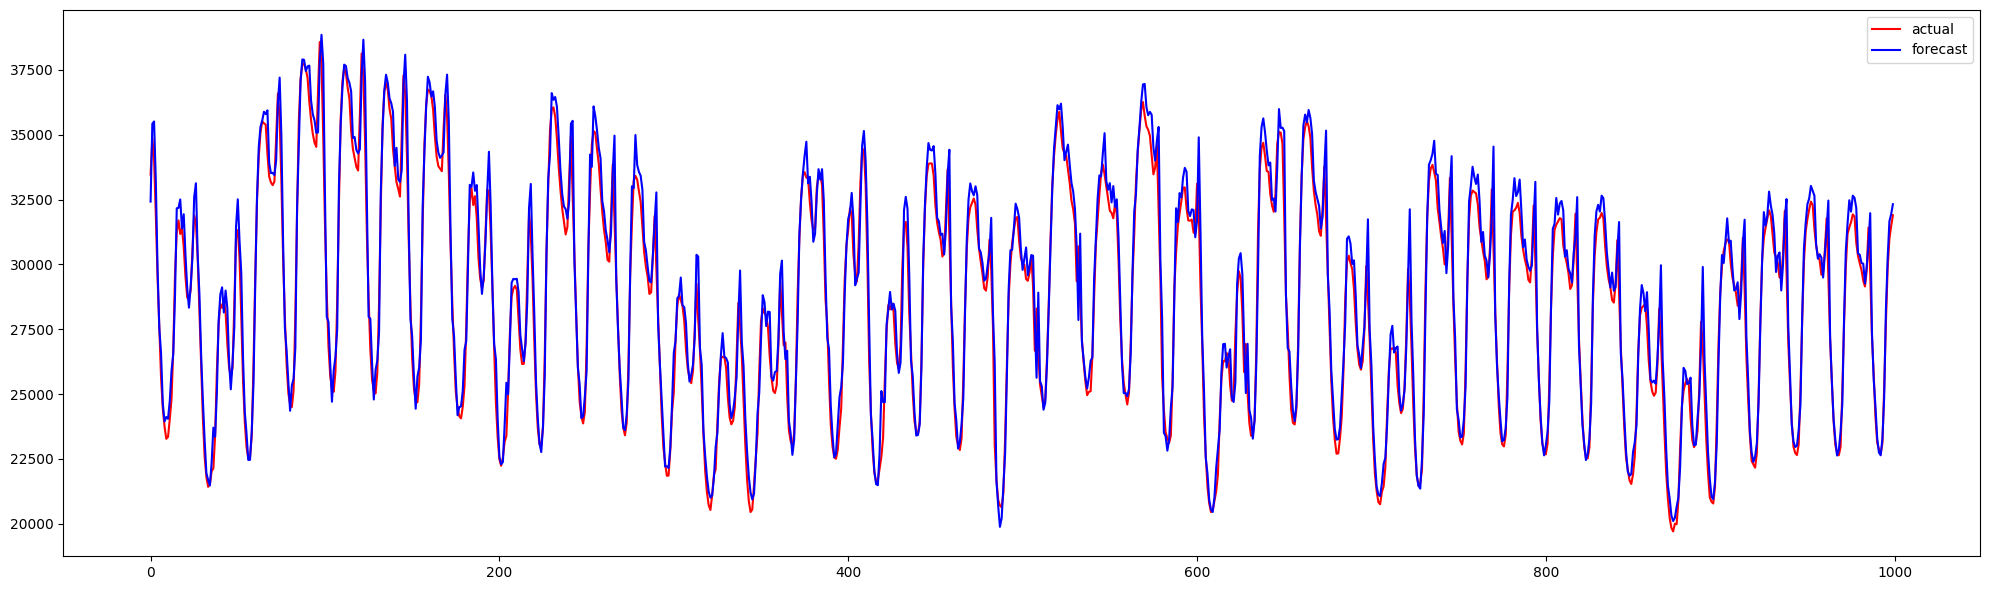

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='actual')
ax.plot(forecast[:1000], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(actual, forecast[:-1])
mae = mean_absolute_error(actual, forecast[:-1])

print(f'mse: {mse}')
print(f'mae: {mae}')

mse: 775539.459801751
mae: 638.5030571383704


##### Single Step Multi-Output

In [ ]:
column_names = dr.columns.to_list()
input_cols = ['total load actual_roll', 'price actual_roll']
target_cols = ['total load actual','price actual']
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size, feature_columns=input_cols, label_columns=target_cols, column_names=column_names)

```
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 48, 2)
shape of second element: (32, 2)
```

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten


# Build CNN-LSTM-DNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu',
                          input_shape=[window_size, len(input_cols)]),
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Lambda(lambda x: x * 100)
])
# Compile the model
model.compile(loss="mse", optimizer="adam")

# Train the model
model.fit(train_set, epochs=30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


877/877 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 364030336.0000
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


877/877 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 110050680.0000
Epoch 3/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 13428641.0000
Epoch 4/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 10538354.0000
Epoch 5/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 10643668.0000
Epoch 6/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 10506933.0000
Epoch 7/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 10514083.0000
Epoch 8/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 10453277.0000
Epoch 9/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 9187261.0000
Epoch 10/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 637877.1875
Epoch 11/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 435872.3438
Epoch 12/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 413240.6250
Epoch 13/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 417022.7500
Epoch 14/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 392528.9688
Epoch 15/30
877/877 ━━━━━━━━━━━━━━

In [ ]:
def model_forecast(model, series,feature_columns, window_size, batch_size):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      feature_columns (list of str or int) - the names or indices of the columns to be used as features
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      Forecast
    """


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series[feature_columns])

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))

    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast


In [ ]:
forecast = model_forecast(model=model, series=val, feature_columns=input_cols, window_size=window_size, batch_size=batch_size)

214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
forecast[:10]

array([[33044.445   ,    57.970284],
       [35736.418   ,    62.147213],
       [37942.465   ,    65.96601 ],
       [35338.15    ,    61.593246],
       [31836.05    ,    56.299828],
       [27483.523   ,    51.265503],
       [26456.973   ,    49.02615 ],
       [25122.248   ,    48.93841 ],
       [24540.568   ,    48.795856],
       [24173.105   ,    48.278683]], dtype=float32)

In [ ]:
val.columns

Index(['total load actual_roll', 'price actual_roll', 'total load actual',
       'price actual'],
      dtype='object')

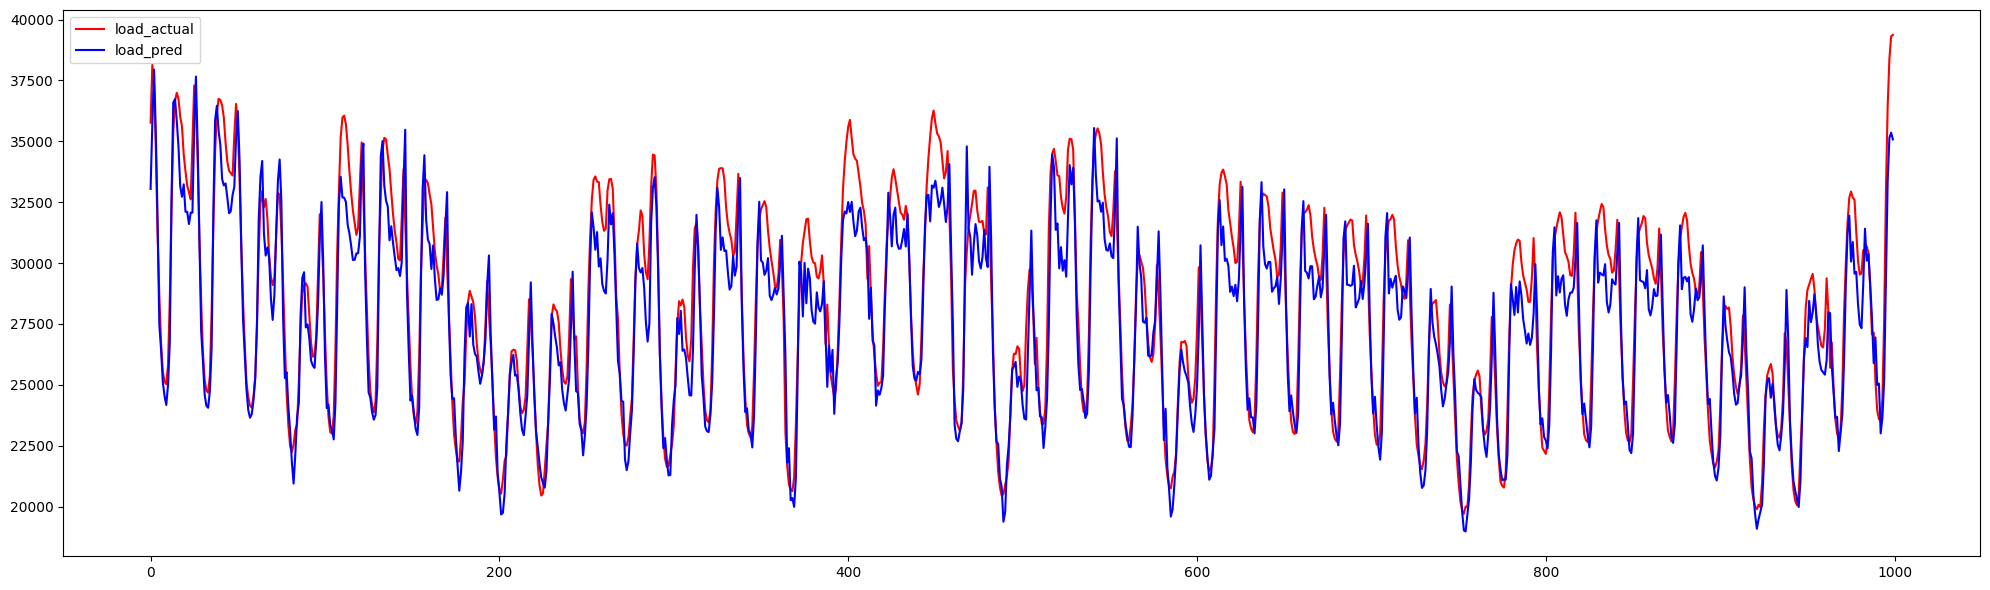

In [ ]:
price_pred = forecast[:-1,0]
actual = val['total load actual'][window_size:].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='load_actual')
ax.plot(price_pred[:1000], c= 'blue', label='load_pred')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
price_pred = forecast[:-1,0]
actual = val['total load actual'][window_size:].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='load_actual')
ax.plot(price_pred[:1000], c= 'blue', label='load_pred')
plt.legend()
plt.tight_layout()
plt.show()

## multi_step

### multi_step_multi-output

This is the most general case, all other cases are just special case of this situation

In [33]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-forecast_size], input_cols, axis=-1),
                                          tf.gather(window[-forecast_size:], output_cols, axis=-1)))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset



In [34]:
column_names = dr.columns.to_list()
input_cols = ['total load actual_roll', 'price actual_roll']
output_cols = ['total load actual','price actual']
forecast_size = 24
train_set = windowed_dataset(train, window_size,
                             batch_size,
                             shuffle_buffer_size,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)

In [35]:
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 48, 2)
shape of second element: (32, 24, 2)


In [39]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten


# Build CNN-LSTM-DNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu',
                          input_shape=[window_size, len(input_cols)]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Lambda(lambda x: x[:,-24:,:] * 100)

])
# Compile the model
model.compile(loss="mse", optimizer="adam")

# Train the model
model.fit(train_set, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


875/875 ━━━━━━━━━━━━━━━━━━━━ 61s 60ms/step - loss: 331302464.0000
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


875/875 ━━━━━━━━━━━━━━━━━━━━ 74s 53ms/step - loss: 23049934.0000
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 48s 50ms/step - loss: 10510657.0000
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - loss: 10537935.0000
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - loss: 10500781.0000
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - loss: 10489641.0000
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 48s 52ms/step - loss: 9877983.0000
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - loss: 4021026.5000
Epoch 9/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - loss: 3719026.7500
Epoch 10/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - loss: 3552470.2500


In [60]:
def valid_windowed_dataset(series, window_size, batch_size, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    # Create tuples with specified features and label
    valid_input = dataset.map(lambda window: tf.gather(window[:-forecast_size], input_cols, axis=-1))
    valid_output = dataset.map(lambda window: tf.gather(window[-forecast_size:], output_cols, axis=-1))
    valid_input = valid_input.batch(batch_size).prefetch(1)
    valid_output = valid_output.batch(batch_size).prefetch(1)

    valid_output_np = []
    for batch in valid_output:
      valid_output_np.append(batch.numpy())

    valid_output_np = np.concatenate(valid_output_np, axis=0)

    return valid_input, valid_output_np


In [61]:
valid_input, valid_output = valid_windowed_dataset(val, window_size, batch_size, forecast_size, input_cols, output_cols, column_names)

In [62]:
prediction = model.predict(valid_input)

217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [63]:
prediction.shape

(6942, 24, 2)

In [64]:
valid_output.shape

(6942, 24, 2)

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Reshape the arrays to 2D for MSE calculation (combine batch and time steps)
prediction_reshaped = prediction.reshape(-1, prediction.shape[-1])
valid_output_reshaped = valid_output.reshape(-1, valid_output.shape[-1])

# Calculate MSE
mse = mean_squared_error(valid_output_reshaped, prediction_reshaped)

# Calculate MAE
mae = mean_absolute_error(valid_output_reshaped, prediction_reshaped)

print(f"Mean Squared Error: {mse}")

print(f"Mean Absolute Error: {mae}")



Mean Squared Error: 3307378.45766116
Mean Absolute Error: 962.4948504060969


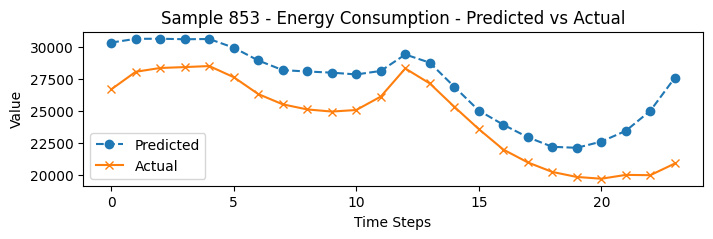

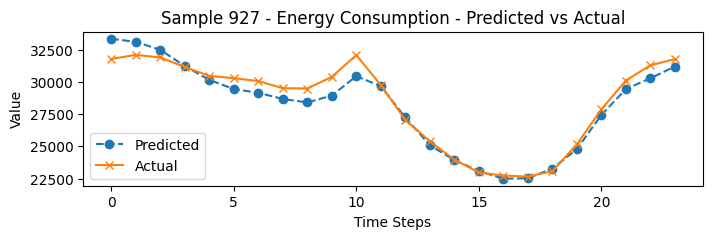

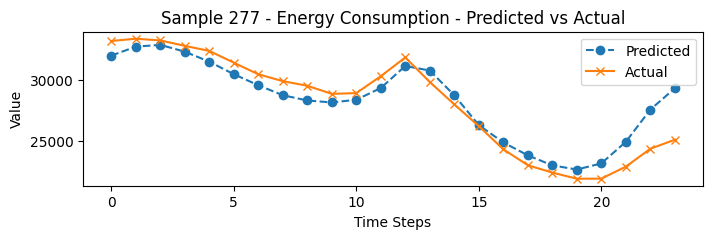

In [74]:

# Step 1: Randomly select 3 indices
num_samples = prediction.shape[0]  # 6942 in this case
random_indices = np.random.choice(num_samples, size=3, replace=False)

# Step 2: Plot the predictions vs. actual values for the selected samples
for i, idx in enumerate(random_indices):
    plt.figure(figsize=(8, 2))
    plt.plot(prediction[idx, :, 0], label="Predicted", linestyle='--', marker='o')
    plt.plot(valid_output[idx, :, 0], label="Actual", linestyle='-', marker='x')
    plt.title(f"Sample {idx} - Energy Consumption - Predicted vs Actual")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

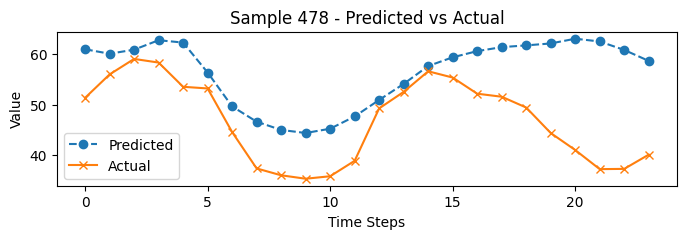

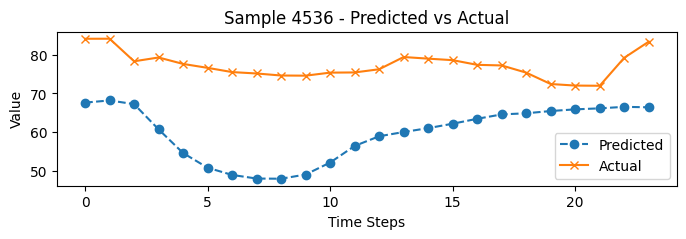

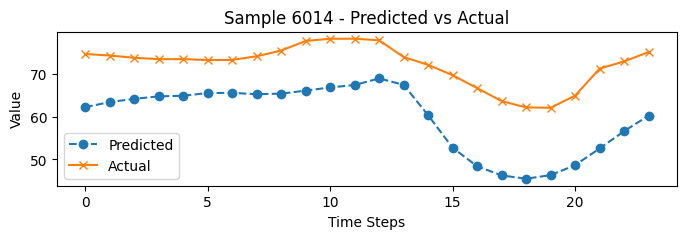

In [73]:

# Step 1: Randomly select 3 indices
num_samples = prediction.shape[0]  # 6942 in this case
random_indices = np.random.choice(num_samples, size=3, replace=False)

# Step 2: Plot the predictions vs. actual values for the selected samples
for i, idx in enumerate(random_indices):
    plt.figure(figsize=(8, 2))
    plt.plot(prediction[idx, :, 1], label="Predicted", linestyle='--', marker='o')
    plt.plot(valid_output[idx, :, 1], label="Actual", linestyle='-', marker='x')
    plt.title(f"Sample {idx} - Price - Predicted vs Actual")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

### Autoregressive model